# AiiDA mini-demo
## Automatic calculations with pseudos from SSSP and k-points from SeeK-path

Some initial imports

In [5]:
from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm import DataFactory, CalculationFactory, Code, load_node
ParameterData=DataFactory('parameter')
import os, time, numpy, pylab
%matplotlib inline

Load the importer from the COD database, and get a silicon supercell (take the first query result)

In [2]:
from aiida.tools.dbimporters import DbImporterFactory
CodImporter = DbImporterFactory('cod')
importer = CodImporter()

In [3]:
all_si_results = list(importer.query(spacegroup="F d -3 m :1", formula="Si"))
cod_result = all_si_results[0] # e.g.: ID 9008565

Convert it to an explicit AiiDA structure, show cell and coordinates

In [4]:
structure = cod_result.get_aiida_structure()

In [5]:
print structure._exportstring('xsf')

CRYSTAL
PRIMVEC 1
      5.4307000000       0.0000000000       0.0000000000
      0.0000000000       5.4307000000       0.0000000000
      0.0000000000       0.0000000000       5.4307000000
PRIMCOORD 1
8 1
14       0.0000000000       0.0000000000       0.0000000000
14       0.0000000000       2.7153500000       2.7153500000
14       2.7153500000       0.0000000000       2.7153500000
14       2.7153500000       2.7153500000       0.0000000000
14       4.0730250000       4.0730250000       1.3576750000
14       4.0730250000       1.3576750000       4.0730250000
14       1.3576750000       4.0730250000       4.0730250000
14       1.3576750000       1.3576750000       1.3576750000



### Get primitive cell from SeeK-path (also standardized according to crystallographic conventions), and show some information

In [6]:
from seekpath.aiidawrappers import get_path, get_explicit_k_path
seekpath_info = get_path(structure)
primitive_structure = seekpath_info['primitive_structure']
explicit_path = get_explicit_k_path(structure)

In [7]:
print "Bravais lattice: {}\nSpacegroup: {}\nInput cell had a volume {}x w.r.t. the primitive cell".format(
    seekpath_info['bravais_lattice_extended'], 
    seekpath_info['spacegroup_international'], 
    int(seekpath_info['volume_original_wrt_prim']))
print "Suggested path: ",
print ", ".join("{}-{}".format(p1, p2) for p1, p2 in seekpath_info['path'])
print "K-point coordinates (scaled units):"
for label, coords in seekpath_info['point_coords'].iteritems():
    print "{:7s} {:18.10f} {:18.10f} {:18.10f}".format(label, *coords)

Bravais lattice: cF2
Spacegroup: Fd-3m
Input cell had a volume 4x w.r.t. the primitive cell
Suggested path:  GAMMA-X, X-U, K-GAMMA, GAMMA-L, L-W, W-X
K-point coordinates (scaled units):
K             0.3750000000       0.3750000000       0.7500000000
L             0.5000000000       0.5000000000       0.5000000000
U             0.6250000000       0.2500000000       0.6250000000
W             0.5000000000       0.2500000000       0.7500000000
X             0.5000000000       0.0000000000       0.5000000000
GAMMA         0.0000000000       0.0000000000       0.0000000000
W_2           0.7500000000       0.2500000000       0.5000000000


<img src="../common/data/bz-cF2.png" alt="Brillouin Zone for cF2" style="width: 500px;"/>

### Get suggested cutoff from SSSP

In [8]:
SSSP_eff_cutoffs = {l.split()[0]: int(l.split()[1]) 
                    for l in open(os.path.join(
                        os.path.dirname(__name__),os.pardir,
                        'common','data','SSSP_acc_cutoffs.txt')).readlines() 
                    if l.split()[1] != '??'}

In [9]:
for elem in sorted(SSSP_eff_cutoffs)[:10]:
    print "{:2s}: {:3.0f} Ry".format(elem, SSSP_eff_cutoffs[elem])
print "   ..."

Ag:  35 Ry
Al:  30 Ry
Ar: 120 Ry
As:  30 Ry
Au:  45 Ry
B :  40 Ry
Ba:  40 Ry
Be:  55 Ry
Bi:  35 Ry
Br:  30 Ry
   ...


Pick the suggested cutoff for this structure, as the largest cutoff for all species in the system

In [10]:
SSSP_cutoff = float(max(SSSP_eff_cutoffs[sym] for sym in structure.get_symbols_set()))
print "Suggested cutoff: {} Ry".format(SSSP_cutoff)

Suggested cutoff: 30.0 Ry


### Pick a suitable regular mesh from a given density; here: 0.4 Angstrom<sup>-1</sup>

In [11]:
KpointsData = DataFactory('array.kpoints')
kpts = KpointsData()
kpts.set_cell_from_structure(primitive_structure)
kpts.set_kpoints_mesh_from_density(distance=0.4, offset=[0.,0.,0.])

In [12]:
print kpts.get_kpoints_mesh()

((6, 6, 6), (0.0, 0.0, 0.0))


### Generate a Quantum ESPRESSO relaxation calculation

In [13]:
calc = Code.get_from_string('pw-5.1@localhost').new_calc()
calc.set_resources({'num_machines': 1})

In [14]:
calc.use_structure(primitive_structure)
calc.use_kpoints(kpts)
calc.use_pseudos_from_family("SSSP")

In [15]:
calc.use_parameters(ParameterData(dict={
    'CONTROL': {
        'calculation': 'relax',
        'restart_mode': 'from_scratch',
    },
    'SYSTEM': {
        'ecutwfc': SSSP_cutoff,
        'ecutrho': 8.*SSSP_cutoff,
    },
    'ELECTRONS': {
        'conv_thr': 1.e-10,
    }}))

In [17]:
calc.store_all()
calc.submit()

In [18]:
while calc.get_state() != 'FINISHED':
    print ".",
    time.sleep(5)
    

. . . . . . . . . . . . . . . . .


In [21]:
#calc = load_node(5049)

In [22]:
bandscalc = calc.create_restart(use_output_structure=True)
bandscalc.set_resources({'num_machines': 1})
bandscalc.use_kpoints(explicit_path['explicit_kpoints'])

bands_parameters = calc.inp.parameters.get_dict()
bands_parameters['CONTROL']['calculation'] = 'bands'
bandscalc.use_parameters(ParameterData(dict=bands_parameters))

bandscalc.use_settings(ParameterData(dict={
    'also_bands': True
}))

In [23]:
bandscalc.store_all()
bandscalc.submit()

In [24]:
while bandscalc.get_state() != 'FINISHED':
    print ".",
    time.sleep(5)

. . . . . . . . . . . . . . .


In [7]:
# bandscalc = load_node(5059)

In [9]:
import json
plot_data = json.loads(
        "\n".join([_.partition('#')[0] 
                   for _ in bandscalc.out.output_band._exportstring('json').splitlines() 
                   if _.partition('#')[0].split()]))

Band structure:


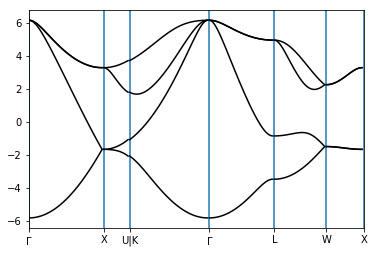

In [19]:
curpos = 0
last_label = None
f = pylab.subplot(1,1,1)
pylab.axvline(curpos)
ticks = []
tick_labels = []
for path in data['paths']:
    if last_label is None:
        ticks.append(curpos)
        tick_labels.append(path['from'])
        last_label = path['from']
    if last_label != path['from']:
        tick_labels[-1] += "|{}".format(path['from'])
    if path['length'] == 1:
        continue
    newlen = 0
    for band in path['values']:
        newlen = len(band)
        pylab.plot(range(curpos, curpos+newlen), band, 'k')
    curpos += newlen
    if newlen == 2:
        print path
    pylab.axvline(curpos) 
    ticks.append(curpos)
    tick_labels.append(path['to'])
    last_label = path['to']
    
pylab.xlim([0, curpos])
f.set_xticks(ticks)

tick_labels = ["$\Gamma$" if _ == "GAMMA" else _ for _ in tick_labels ]

f.set_xticklabels(tick_labels)
print 'Band structure:'